# Preliminaries

### Import data and packages

Import numpy and pandas.
Import categorical encoding, necessary layers and Model from keras.
Import matplotlib for plotting accuracies

In [1]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt

Load datasets into pandas

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Inspection

I set some parameters:

m  = number of training examples,

dt = total number of pixels,

d  = number of pixels on dimension of the matrix (square root of d2),

n  = number of classes.

In [4]:
m=train.shape[0]
dt=train.shape[1]-1
d=int(np.sqrt(dt))
n=len(train.label.value_counts())
print([m,dt,d,n])

[42000, 784, 28, 10]


I check that neither the training nor the test sets have missing values

In [5]:
test.columns[pd.concat([train.drop('label',axis=1),test]).isnull().sum()>0]

Index([], dtype='object')

I check that there is an even distribution of training examples across the different classes

In [6]:
train['label'].value_counts(sort=False)

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

Some statistics on the pixel values. 
I compute Pixel_stats for each pixel, using all training example. 
Then I get statistics for each Pixel_stat.
For example, the minimum value for each pixel is always 0, but the maximum value is not always 255.

In [7]:
train.drop('label',axis=1).describe().T.drop('count',axis=1).describe().drop('count',axis=0).add_prefix('Pixel_')

,Pixel_mean,Pixel_std,Pixel_min,Pixel_25%,Pixel_50%,Pixel_75%,Pixel_max
mean,33.408911,49.307334,0.0,0.0,12.241709,62.629145,217.676020
std,42.573157,44.174709,0.0,0.0,33.240031,99.211592,83.830621
min,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,0.129470,4.626490,0.0,0.0,0.000000,0.000000,255.000000
50%,7.231500,36.771597,0.0,0.0,0.000000,0.000000,255.000000
75%,69.034262,100.692231,0.0,0.0,0.000000,153.187500,255.000000
max,139.826143,113.850143,0.0,0.0,173.000000,253.000000,255.000000


# Dense Network

### Data Preparation

I get the dataset ready for usage with keras.

Max: maximum pixel value in the training dataset

x: array of pixel values from training dataset, normalized by Max

y: labels transformed into n-dimensional array

x_test: array of pixel values from test dataset, normalized by Max

In [8]:
Max=train.max().max()
x=train.iloc[:,1:].values/Max
y=to_categorical(train.label,n)
x_test=test.values/Max
print([x.shape,x.max(),y.shape])
print([x_test.shape,x_test.max()])

[(42000, 784), 1.0, (42000, 10)]
[(28000, 784), 1.0]


I check that the categorical encoding of y with '1' at position 'i' of the n-dim array corresponds to label 'i'

In [9]:
[set(train.label[np.argmax(y,axis=1)==i])=={i} for i in range(10)]

[True, True, True, True, True, True, True, True, True, True]

### Definition of the Model

I define a fully connected network.
Each hidden layer uses ReLU as activation function, and I use dropout after each of them for regularization.
The number of neurons in each layer is given by the input array dims.
The output layer has n neurons and uses softmax activation.

In [10]:
def DenseModel(dims,dropout_rate):
    X_input=Input(shape=(dt))
    X=X_input
    for dim in dims:
        X=Dense(dim,activation='relu')(X)
        X=Dropout(dropout_rate)(X)
    X_output=Dense(n,activation='softmax')(X)
    model=Model(inputs=X_input,outputs=X_output)
    return model

### Model 1

The first model I create has 5 hidden layers with dimensions (392, 196, 196, 98, 98), and 35% dropout rate.
I fit the model with 20 epochs of training, batch size of 128 examples, and 20% of the dataset left for validation.

In [13]:
dims=[dt//2,dt//4,dt//4,dt//8,dt//8]
model1=DenseModel(dims,0.35)
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
dropout_5 (Dropout)          (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 196)               77028     
_________________________________________________________________
dropout_6 (Dropout)          (None, 196)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 196)               38612     
_________________________________________________________________
dropout_7 (Dropout)          (None, 196)              

In [14]:
hist1=model1.fit(x,y,batch_size=128,epochs=20,validation_split=0.2)

Epoch 1/20
263/263 [==============================] - 2s 8ms/step - loss: 0.8678 - accuracy: 0.7097 - val_loss: 0.2213 - val_accuracy: 0.9377
Epoch 2/20
263/263 [==============================] - 2s 9ms/step - loss: 0.3027 - accuracy: 0.9196 - val_loss: 0.1788 - val_accuracy: 0.9540
Epoch 3/20
263/263 [==============================] - 2s 8ms/step - loss: 0.2253 - accuracy: 0.9410 - val_loss: 0.1365 - val_accuracy: 0.9646
Epoch 4/20
263/263 [==============================] - 2s 8ms/step - loss: 0.1926 - accuracy: 0.9500 - val_loss: 0.1248 - val_accuracy: 0.9671
Epoch 5/20
263/263 [==============================] - 2s 9ms/step - loss: 0.1567 - accuracy: 0.9591 - val_loss: 0.1265 - val_accuracy: 0.9685
Epoch 6/20
263/263 [==============================] - 2s 9ms/step - loss: 0.1383 - accuracy: 0.9635 - val_loss: 0.1100 - val_accuracy: 0.9729
Epoch 7/20
263/263 [==============================] - 2s 8ms/step - loss: 0.1283 - accuracy: 0.9665 - val_loss: 0.1137 - val_accuracy: 0.9701
Epoch 

Plot the training and validation costs for each epoch

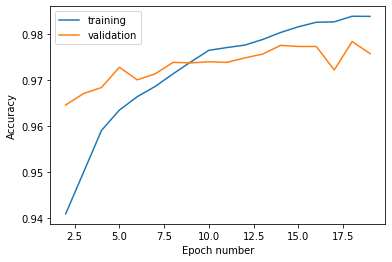

In [68]:
plt.plot(range(2,20),hist1.history['accuracy'][2:],range(2,20),hist1.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

I set the prediction to the the class with the highest probability in the output layer (softmax) 

In [20]:
pred1=pd.DataFrame({'ImageId':range(1,len(x_test)+1),'Label':model1.predict(x_test).argmax(axis=1)}).set_index('ImageId')

In [80]:
pred1.to_csv('pred1.csv')

### Model2

The second model has 7 hidden layers with dimensions (784, 784, 392, 392, 196, 196, 98), and 35% dropout rate.
I fit the model with 25 epochs of training, batch size of 128 examples, and 20% of the dataset left for validation.

In [16]:
dims=[dt,dt,dt//2,dt//2,dt//4,dt//4,dt//8]
model2=DenseModel(dims,0.35)
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_10 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_11 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 392)               307720    
_________________________________________________________________
dropout_12 (Dropout)         (None, 392)              

In [17]:
hist2=model2.fit(x,y,batch_size=128,epochs=25,validation_split=0.2)

Epoch 1/25
263/263 [==============================] - 8s 29ms/step - loss: 0.9251 - accuracy: 0.6846 - val_loss: 0.2491 - val_accuracy: 0.9352
Epoch 2/25
263/263 [==============================] - 7s 27ms/step - loss: 0.2872 - accuracy: 0.9306 - val_loss: 0.1674 - val_accuracy: 0.9579
Epoch 3/25
263/263 [==============================] - 7s 26ms/step - loss: 0.2112 - accuracy: 0.9496 - val_loss: 0.1600 - val_accuracy: 0.9604
Epoch 4/25
263/263 [==============================] - 8s 31ms/step - loss: 0.1742 - accuracy: 0.9592 - val_loss: 0.1326 - val_accuracy: 0.9687
Epoch 5/25
263/263 [==============================] - 8s 31ms/step - loss: 0.1528 - accuracy: 0.9636 - val_loss: 0.1293 - val_accuracy: 0.9685
Epoch 6/25
263/263 [==============================] - 8s 31ms/step - loss: 0.1330 - accuracy: 0.9686 - val_loss: 0.1259 - val_accuracy: 0.9707
Epoch 7/25
263/263 [==============================] - 9s 33ms/step - loss: 0.1259 - accuracy: 0.9694 - val_loss: 0.1291 - val_accuracy: 0.9726

Plot the training and validation costs for each epoch

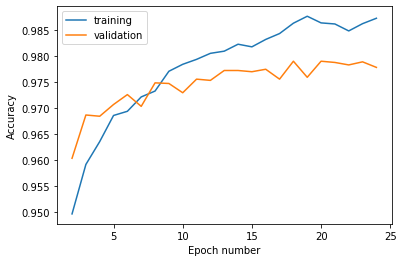

In [69]:
plt.plot(range(2,25),hist2.history['accuracy'][2:],range(2,25),hist2.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

I check that almost 2% of the predictions differ compared with the previous model

In [21]:
pred2=pd.DataFrame({'ImageId':range(1,len(x_test)+1),'Label':model2.predict(x_test).argmax(axis=1)}).set_index('ImageId')

In [22]:
pred2.join(pred1, lsuffix='1',rsuffix='2').apply(lambda x: x.Label1==x.Label2,axis=1).value_counts()/len(x_test)

True     0.980071
False    0.019929
dtype: float64

In [81]:
pred2.to_csv('pred2.csv')

### Model 3

Third model has 9 hidden layers, dimensions are (784, 784, 784, 392, 392, 392, 196, 196, 196), and 35% dropout rate.
I fit the model with 30 epochs of training, batch size of 128 examples, and 20% of the dataset left for validation.

In [23]:
dims=[dt,dt,dt,dt//2,dt//2,dt//2,dt//4,dt//4,dt//4]
model3=DenseModel(dims,0.35)
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_17 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_18 (Dropout)         (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_19 (Dropout)         (None, 784)              

In [24]:
hist3=model3.fit(x,y,batch_size=128,epochs=30,validation_split=0.2)

Epoch 1/30
263/263 [==============================] - 13s 49ms/step - loss: 1.3892 - accuracy: 0.4756 - val_loss: 0.4090 - val_accuracy: 0.8639
Epoch 2/30
263/263 [==============================] - 13s 48ms/step - loss: 0.3809 - accuracy: 0.9020 - val_loss: 0.2086 - val_accuracy: 0.9523
Epoch 3/30
263/263 [==============================] - 12s 47ms/step - loss: 0.2676 - accuracy: 0.9386 - val_loss: 0.1752 - val_accuracy: 0.9614
Epoch 4/30
263/263 [==============================] - 12s 45ms/step - loss: 0.2261 - accuracy: 0.9507 - val_loss: 0.1662 - val_accuracy: 0.9601
Epoch 5/30
263/263 [==============================] - 11s 43ms/step - loss: 0.1833 - accuracy: 0.9596 - val_loss: 0.1389 - val_accuracy: 0.9686
Epoch 6/30
263/263 [==============================] - 12s 45ms/step - loss: 0.1656 - accuracy: 0.9639 - val_loss: 0.1350 - val_accuracy: 0.9695
Epoch 7/30
263/263 [==============================] - 13s 49ms/step - loss: 0.1510 - accuracy: 0.9667 - val_loss: 0.1259 - val_accuracy:

Plot the training and validation costs for each epoch

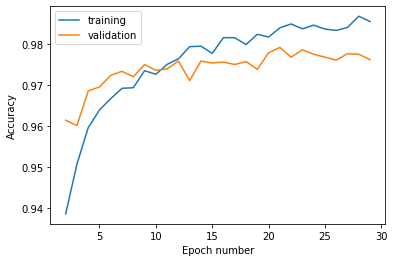

In [70]:
plt.plot(range(2,30),hist3.history['accuracy'][2:],range(2,30),hist3.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

I check that around 2% of the predictions differ compared with both model 1 and 2.

In [26]:
pred3=pd.DataFrame({'ImageId':range(1,len(x_test)+1),'Label':model3.predict(x_test).argmax(axis=1)}).set_index('ImageId')

In [27]:
pred3.join(pred1, lsuffix='1',rsuffix='2').apply(lambda x: x.Label1==x.Label2,axis=1).value_counts()/len(x_test)

True     0.979964
False    0.020036
dtype: float64

In [28]:
pred3.join(pred2, lsuffix='1',rsuffix='2').apply(lambda x: x.Label1==x.Label2,axis=1).value_counts()/len(x_test)

True     0.978393
False    0.021607
dtype: float64

In [82]:
pred3.to_csv('pred3.csv')

# Convolutional Networks

### Data Preparation

Now I create the datasets for convolutional neural networks.

x_conv: 28 by 28 array of pixel values from training dataset, normalized by Max

x_conv_test: 28 by 28 array of pixel values from test dataset, normalized by Max

In [29]:
x_conv=train.values[:,1:].reshape((m,d,d,1))/Max
x_conv_test=test.values.reshape((-1,d,d,1))/Max
y=to_categorical(train.label,n)
print([x_conv.shape,x_conv.max(),y.shape])
print([x_conv_test.shape,x_conv_test.max()])

[(42000, 28, 28, 1), 1.0, (42000, 10)]
[(28000, 28, 28, 1), 1.0]


### Definition of the Model

I define a convolutional neural network.
Each hidden layer uses ReLU as activation function, and I use dropout after each of them for regularization.
The number of filters in each convolutional layer, the kernel sizes and strides are given as input arrays.
I use square filters, with the same stride on both dimensions. I always use 'same' padding.
After convolutional layers I flatten and apply a fully connected layer, with dimension given as input.
The output layer has n neurons and uses softmax activation

In [30]:
def ConvModel(dims,kernels,strides,dim_dense,dropout_rate):
    data=np.array([dims,kernels,strides]).T
    X_input=Input(shape=(d,d,1))
    X=X_input
    for dim,kernel,stride in data:
        X=Conv2D(dim,kernel_size=(kernel,kernel),strides=(stride,stride),padding='same',activation='relu')(X)
        X=Dropout(dropout_rate)(X)
    X=Flatten()(X)
    X=Dense(dim_dense,activation='relu')(X)
    X_output=Dense(n,activation='softmax')(X)
    model=Model(inputs=X_input,outputs=X_output)
    return model

### Model 1

Generically I increase the number of filters as I reduce the size of the matrices. All kernels are 3x3.
I start with 28x28x1 and go to 14x14x32 with a stride of 2.
I then use 'same' padding and unit stride to stay with 14x14 window, but increase to 64 filters.
Finally I use stride of 2 again to go to 7x7x128.
I use 128 neurons in the hidden dense layer.
I fit the model with 15 epochs of training, 35% dropout, and 20% of the dataset left for validation.

In [32]:
convmodel1=ConvModel([32,64,128],[3,3,3],[2,1,2],128,0.35)
convmodel1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel1.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
dropout_27 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
dropout_28 (Dropout)         (None, 7, 7, 128)        

In [33]:
convhist1=convmodel1.fit(x_conv,y,batch_size=128,epochs=15,validation_split=0.2)

Epoch 1/15
263/263 [==============================] - 36s 136ms/step - loss: 0.3495 - accuracy: 0.8933 - val_loss: 0.0999 - val_accuracy: 0.9687
Epoch 2/15
263/263 [==============================] - 36s 137ms/step - loss: 0.1038 - accuracy: 0.9681 - val_loss: 0.0680 - val_accuracy: 0.9786
Epoch 3/15
263/263 [==============================] - 35s 134ms/step - loss: 0.0721 - accuracy: 0.9783 - val_loss: 0.0569 - val_accuracy: 0.9813
Epoch 4/15
263/263 [==============================] - 35s 133ms/step - loss: 0.0578 - accuracy: 0.9819 - val_loss: 0.0472 - val_accuracy: 0.9849
Epoch 5/15
263/263 [==============================] - 35s 132ms/step - loss: 0.0456 - accuracy: 0.9844 - val_loss: 0.0411 - val_accuracy: 0.9879
Epoch 6/15
263/263 [==============================] - 36s 136ms/step - loss: 0.0386 - accuracy: 0.9878 - val_loss: 0.0422 - val_accuracy: 0.9873
Epoch 7/15
263/263 [==============================] - 35s 133ms/step - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.0397 - val_ac

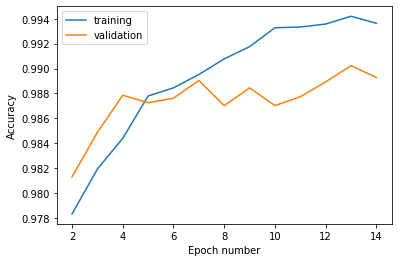

In [71]:
plt.plot(range(2,15),convhist1.history['accuracy'][2:],range(2,15),convhist1.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [36]:
convpred1=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel1.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [83]:
convpred1.to_csv('convpred1.csv')

### Model 2

I use more hidden layers, but still all kernels are 3x3.
Number of filters is 32,64 and 128, twice each. 
I half the size of the window every two layers (to 14x14, 7x7 and 4x4).
I use 256 neurons in the hidden dense layer.
I fit the model with 20 epochs of training, 35% dropout, and 20% of the dataset left for validation.

In [37]:
convmodel2=ConvModel([32,32,64,64,128,128],[3,3,3,3,3,3],[2,1,2,1,2,1],256,0.35)
convmodel2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel2.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
dropout_29 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
dropout_31 (Dropout)         (None, 7, 7, 64)        

In [38]:
convhist2=convmodel2.fit(x_conv,y,batch_size=128,epochs=20,validation_split=0.2)

Epoch 1/20
263/263 [==============================] - 46s 174ms/step - loss: 0.5498 - accuracy: 0.8142 - val_loss: 0.1168 - val_accuracy: 0.9631
Epoch 2/20
263/263 [==============================] - 43s 165ms/step - loss: 0.1583 - accuracy: 0.9503 - val_loss: 0.0738 - val_accuracy: 0.9736
Epoch 3/20
263/263 [==============================] - 45s 171ms/step - loss: 0.1209 - accuracy: 0.9623 - val_loss: 0.0568 - val_accuracy: 0.9811
Epoch 4/20
263/263 [==============================] - 45s 172ms/step - loss: 0.0967 - accuracy: 0.9691 - val_loss: 0.0501 - val_accuracy: 0.9849
Epoch 5/20
263/263 [==============================] - 41s 156ms/step - loss: 0.0854 - accuracy: 0.9733 - val_loss: 0.0471 - val_accuracy: 0.9850
Epoch 6/20
263/263 [==============================] - 44s 168ms/step - loss: 0.0756 - accuracy: 0.9751 - val_loss: 0.0423 - val_accuracy: 0.9875
Epoch 7/20
263/263 [==============================] - 50s 190ms/step - loss: 0.0689 - accuracy: 0.9786 - val_loss: 0.0411 - val_ac

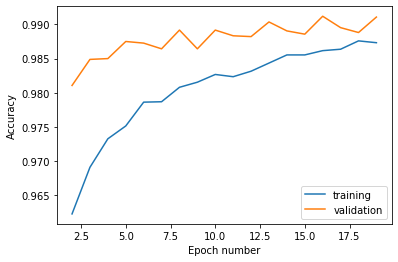

In [72]:
plt.plot(range(2,20),convhist2.history['accuracy'][2:],range(2,20),convhist2.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [40]:
convpred2=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel2.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [84]:
convpred2.to_csv('convpred2.csv')

### Model 3

I try a simpler network now, with just two concolutional layers, dimensions are 32 and 64, windows 14x14 and 7x7.
Dense layer with 128 neurons. I use 13 epochs of training, 35% dropout rate, and 20% train/dev partitioning.

In [41]:
convmodel3=ConvModel([32,64],[3,3],[2,2],128,0.35)
convmodel3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel3.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
dropout_35 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
dropout_36 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)             

In [42]:
convhist3=convmodel3.fit(x_conv,y,batch_size=128,epochs=13,validation_split=0.2)

Epoch 1/13
263/263 [==============================] - 13s 48ms/step - loss: 0.4406 - accuracy: 0.8677 - val_loss: 0.1473 - val_accuracy: 0.9544
Epoch 2/13
263/263 [==============================] - 11s 41ms/step - loss: 0.1571 - accuracy: 0.9501 - val_loss: 0.0965 - val_accuracy: 0.9687
Epoch 3/13
263/263 [==============================] - 10s 37ms/step - loss: 0.1101 - accuracy: 0.9661 - val_loss: 0.0777 - val_accuracy: 0.9738
Epoch 4/13
263/263 [==============================] - 12s 47ms/step - loss: 0.0870 - accuracy: 0.9735 - val_loss: 0.0677 - val_accuracy: 0.9781
Epoch 5/13
263/263 [==============================] - 11s 40ms/step - loss: 0.0718 - accuracy: 0.9780 - val_loss: 0.0553 - val_accuracy: 0.9821
Epoch 6/13
263/263 [==============================] - 10s 37ms/step - loss: 0.0629 - accuracy: 0.9800 - val_loss: 0.0519 - val_accuracy: 0.9829
Epoch 7/13
263/263 [==============================] - 11s 41ms/step - loss: 0.0532 - accuracy: 0.9827 - val_loss: 0.0525 - val_accuracy:

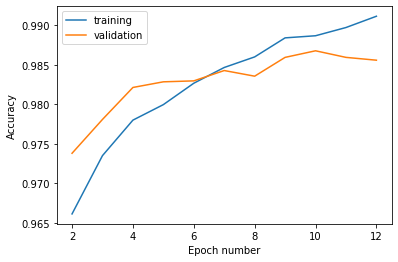

In [73]:
plt.plot(range(2,13),convhist3.history['accuracy'][2:],range(2,13),convhist3.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [44]:
convpred3=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel3.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [85]:
convpred3.to_csv('convpred3.csv')

### Definition of Model with Batch Normalization

I define a new convolutional neural network, with batch normalization layers between convolution and activation

In [45]:
def ConvModel2(dims,kernels,strides,dim_dense,dropout_rate):
    data=np.array([dims,kernels,strides]).T
    X_input=Input(shape=(d,d,1))
    X=X_input
    for dim,kernel,stride in data:
        X=Conv2D(dim,kernel_size=(kernel,kernel),strides=(stride,stride),padding='same',use_bias=False)(X)
        X=BatchNormalization()(X)
        X=Activation('relu')(X)
        X=Dropout(dropout_rate)(X)
    X=Flatten()(X)
    X=Dense(dim_dense,use_bias=False)(X)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X_output=Dense(n,activation='softmax')(X)
    model=Model(inputs=X_input,outputs=X_output)
    return model

### Model 4

Like convolutional model 1 (4 hidden layers), but with batch normalization

In [46]:
convmodel4=ConvModel2([32,64,128],[3,3,3],[2,1,2],128,0.35)
convmodel4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel4.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)      

In [47]:
convhist4=convmodel4.fit(x_conv,y,batch_size=128,epochs=15,validation_split=0.2)

Epoch 1/15
263/263 [==============================] - 46s 176ms/step - loss: 0.3118 - accuracy: 0.9078 - val_loss: 1.3978 - val_accuracy: 0.5598
Epoch 2/15
263/263 [==============================] - 50s 191ms/step - loss: 0.0941 - accuracy: 0.9718 - val_loss: 0.1087 - val_accuracy: 0.9663
Epoch 3/15
263/263 [==============================] - 41s 155ms/step - loss: 0.0677 - accuracy: 0.9794 - val_loss: 0.0461 - val_accuracy: 0.9852
Epoch 4/15
263/263 [==============================] - 44s 168ms/step - loss: 0.0555 - accuracy: 0.9834 - val_loss: 0.0381 - val_accuracy: 0.9877
Epoch 5/15
263/263 [==============================] - 41s 156ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.0356 - val_accuracy: 0.9887
Epoch 6/15
263/263 [==============================] - 44s 168ms/step - loss: 0.0362 - accuracy: 0.9885 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 7/15
263/263 [==============================] - 47s 179ms/step - loss: 0.0366 - accuracy: 0.9884 - val_loss: 0.0304 - val_ac

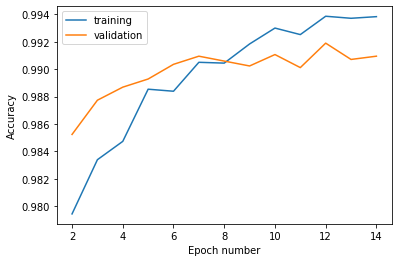

In [74]:
plt.plot(range(2,15),convhist4.history['accuracy'][2:],range(2,15),convhist4.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [49]:
convpred4=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel4.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [86]:
convpred4.to_csv('convpred4.csv')

### Model 5

Like Convolutional model 2 (7 hidden layers), but with batch normalization

In [50]:
convmodel5=ConvModel2([32,32,64,64,128,128],[3,3,3,3,3,3],[2,1,2,1,2,1],256,0.35)
convmodel5.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel5.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        288       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        9216      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)      

In [51]:
convhist5=convmodel5.fit(x_conv,y,batch_size=128,epochs=20,validation_split=0.2)

Epoch 1/20
263/263 [==============================] - 55s 210ms/step - loss: 0.6147 - accuracy: 0.7951 - val_loss: 5.1121 - val_accuracy: 0.1401
Epoch 2/20
263/263 [==============================] - 55s 210ms/step - loss: 0.1877 - accuracy: 0.9404 - val_loss: 0.3533 - val_accuracy: 0.9058
Epoch 3/20
263/263 [==============================] - 63s 240ms/step - loss: 0.1333 - accuracy: 0.9571 - val_loss: 0.0574 - val_accuracy: 0.9815
Epoch 4/20
263/263 [==============================] - 48s 183ms/step - loss: 0.1089 - accuracy: 0.9657 - val_loss: 0.0472 - val_accuracy: 0.9846
Epoch 5/20
263/263 [==============================] - 56s 213ms/step - loss: 0.0951 - accuracy: 0.9690 - val_loss: 0.0467 - val_accuracy: 0.9832
Epoch 6/20
263/263 [==============================] - 48s 184ms/step - loss: 0.0851 - accuracy: 0.9717 - val_loss: 0.0508 - val_accuracy: 0.9824
Epoch 7/20
263/263 [==============================] - 58s 220ms/step - loss: 0.0748 - accuracy: 0.9757 - val_loss: 0.0412 - val_ac

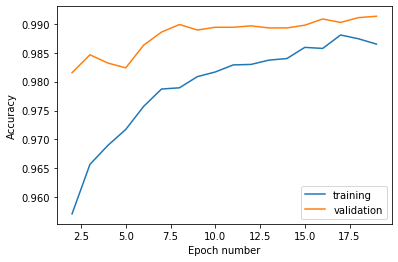

In [75]:
plt.plot(range(2,20),convhist5.history['accuracy'][2:],range(2,20),convhist5.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [53]:
convpred5=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel5.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [87]:
convpred5.to_csv('convpred5.csv')

### Definition of Model with Batch Normalization and Pooling

Finally, I create yet a third type of model, where there is a pooling layer between activation and dropout.
The idea is that I will now be able to decrease the window size with pooling instead of using wider strides.

In [54]:
def ConvModel3(dims,kernels,strides,pools,dim_dense,dropout_rate):
    data=np.array([dims,kernels,strides,pools]).T
    X_input=Input(shape=(d,d,1))
    X=X_input
    for dim,kernel,stride,pool in data:
        X=Conv2D(dim,kernel_size=(kernel,kernel),strides=(stride,stride),padding='same',use_bias=False)(X)
        X=BatchNormalization()(X)
        X=Activation('relu')(X)
        X=MaxPooling2D(pool_size=(pool,pool),strides=(pool,pool),padding='same')(X)
        X=Dropout(dropout_rate)(X)
    X=Flatten()(X)
    X=Dense(dim_dense,use_bias=False)(X)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    X_output=Dense(n,activation='softmax')(X)
    model=Model(inputs=X_input,outputs=X_output)
    return model

### Model 6

Like Convolutional model 1 (4 hidden layers), but with batch normalization and pooling.
All strides are set to 1. I pool with 2x2 filters after some of the convolutional layers. 

In [55]:
convmodel6=ConvModel3([32,64,128],[3,3,3],[1,1,1],[2,1,2],128,0.35)
convmodel6.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel6.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 64)      

In [56]:
convhist6=convmodel6.fit(x_conv,y,batch_size=128,epochs=15,validation_split=0.2)

Epoch 1/15
263/263 [==============================] - 92s 349ms/step - loss: 0.2434 - accuracy: 0.9285 - val_loss: 7.4472 - val_accuracy: 0.1131
Epoch 2/15
263/263 [==============================] - 86s 327ms/step - loss: 0.0812 - accuracy: 0.9762 - val_loss: 0.8908 - val_accuracy: 0.7539
Epoch 3/15
263/263 [==============================] - 80s 305ms/step - loss: 0.0588 - accuracy: 0.9822 - val_loss: 0.0525 - val_accuracy: 0.9833
Epoch 4/15
263/263 [==============================] - 80s 304ms/step - loss: 0.0501 - accuracy: 0.9843 - val_loss: 0.0381 - val_accuracy: 0.9873
Epoch 5/15
263/263 [==============================] - 80s 305ms/step - loss: 0.0396 - accuracy: 0.9879 - val_loss: 0.0285 - val_accuracy: 0.9920
Epoch 6/15
263/263 [==============================] - 81s 306ms/step - loss: 0.0366 - accuracy: 0.9886 - val_loss: 0.0339 - val_accuracy: 0.9904
Epoch 7/15
263/263 [==============================] - 81s 307ms/step - loss: 0.0325 - accuracy: 0.9901 - val_loss: 0.0286 - val_ac

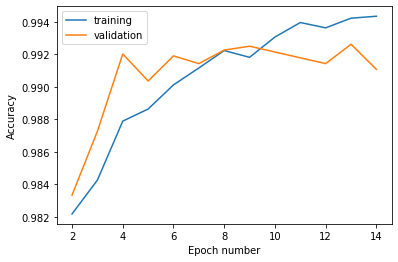

In [76]:
plt.plot(range(2,15),convhist6.history['accuracy'][2:],range(2,15),convhist6.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [58]:
convpred6=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel6.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [88]:
convpred6.to_csv('convpred6.csv')

### Model 7

Like Convolutional model 2 (7 hidden layers), but with batch normalization and pooling.

In [59]:
convmodel7=ConvModel3([32,32,64,64,128,128],[3,3,3,3,3,3],[1,1,1,1,1,1],[2,1,2,1,2,1],256,0.35)
convmodel7.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
convmodel7.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        288       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)      

In [60]:
convhist7=convmodel7.fit(x_conv,y,batch_size=128,epochs=20,validation_split=0.2)

Epoch 1/20
263/263 [==============================] - 80s 303ms/step - loss: 0.5847 - accuracy: 0.8035 - val_loss: 9.6939 - val_accuracy: 0.1131
Epoch 2/20
263/263 [==============================] - 79s 301ms/step - loss: 0.1605 - accuracy: 0.9500 - val_loss: 0.8700 - val_accuracy: 0.7917
Epoch 3/20
263/263 [==============================] - 79s 301ms/step - loss: 0.1150 - accuracy: 0.9626 - val_loss: 0.1211 - val_accuracy: 0.9626
Epoch 4/20
263/263 [==============================] - 79s 300ms/step - loss: 0.0917 - accuracy: 0.9710 - val_loss: 0.0522 - val_accuracy: 0.9830
Epoch 5/20
263/263 [==============================] - 79s 302ms/step - loss: 0.0799 - accuracy: 0.9751 - val_loss: 0.0752 - val_accuracy: 0.9763
Epoch 6/20
263/263 [==============================] - 79s 302ms/step - loss: 0.0695 - accuracy: 0.9770 - val_loss: 0.0392 - val_accuracy: 0.9887
Epoch 7/20
263/263 [==============================] - 80s 303ms/step - loss: 0.0638 - accuracy: 0.9796 - val_loss: 0.0356 - val_ac

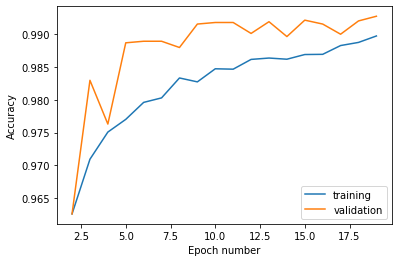

In [77]:
plt.plot(range(2,20),convhist7.history['accuracy'][2:],range(2,20),convhist7.history['val_accuracy'][2:])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [62]:
convpred7=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel7.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [89]:
convpred7.to_csv('convpred7.csv')

Looking at the plot above, it seems I should train it a bit longer

In [67]:
convhist7b=convmodel7.fit(x_conv,y,batch_size=128,epochs=8,validation_split=0.2)

Epoch 1/8
263/263 [==============================] - 100s 380ms/step - loss: 0.0342 - accuracy: 0.9885 - val_loss: 0.0264 - val_accuracy: 0.9937
Epoch 2/8
263/263 [==============================] - 96s 363ms/step - loss: 0.0317 - accuracy: 0.9889 - val_loss: 0.0241 - val_accuracy: 0.9931
Epoch 3/8
263/263 [==============================] - 95s 360ms/step - loss: 0.0312 - accuracy: 0.9893 - val_loss: 0.0265 - val_accuracy: 0.9935
Epoch 4/8
263/263 [==============================] - 92s 349ms/step - loss: 0.0274 - accuracy: 0.9907 - val_loss: 0.0309 - val_accuracy: 0.9917
Epoch 5/8
263/263 [==============================] - 96s 366ms/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0301 - val_accuracy: 0.9919
Epoch 6/8
263/263 [==============================] - 83s 317ms/step - loss: 0.0285 - accuracy: 0.9906 - val_loss: 0.0232 - val_accuracy: 0.9940
Epoch 7/8
263/263 [==============================] - 82s 312ms/step - loss: 0.0264 - accuracy: 0.9913 - val_loss: 0.0312 - val_accuracy

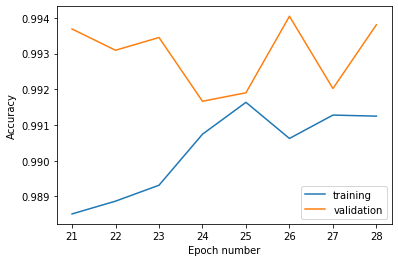

In [79]:
plt.plot(range(21,29),convhist7b.history['accuracy'],range(21,29),convhist7b.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch number')
plt.legend(['training','validation'])
plt.show()

In [90]:
convpred7b=pd.DataFrame({'ImageId':range(1,len(x_conv_test)+1),'Label':convmodel7.predict(x_conv_test).argmax(axis=1)}).set_index('ImageId')

In [91]:
convpred7b.to_csv('convpred7b.csv')